# Guiding questions

In Columbia, for every field, what has race/ethnicity representation looked like in the last twenty years?

In [10]:
from collections import defaultdict
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first convert the GSS export, a table representation of a nested tree, into a nested dictionary.

In [2]:
# Read in CSV
df = pd.read_csv(
    '../../data/GSS_Export_Broad_RaceandEthnicity.csv', 
    header=4, # start table from 4th row of data
    skipfooter=4, # ignore last 4 lines of data (footer)
    engine='python', # default pandas engine does not support skipfooter
    index_col=False, # don't use first column (year) as dataframe index
)

# Rename columns for better readability
df.columns = ['Year', 'Institution Name', 'Broad Fields', 'Race and Ethnicity', 'Count']

# Remove Institution Name column (we know it's all Columbia)
df.drop('Institution Name', axis=1, inplace=True)

df['Count'] = df['Count'].str.replace(',', '') # remove all thousands-commas
df = df.astype({ 'Count': int }) # Convert column "Count" to integers

df.head()

,Year,Broad Fields,Race and Ethnicity,Count
0,2016,Total for selected values,Total for selected values,6498
1,2016,Total for selected values,Total for selected values,6498
2,2016,Biological sciences,Total for selected values,790
3,2016,Biological sciences,Ethnicity and race unknown or not stated,12
4,2016,Biological sciences,"Foreign nationals holding temporary visas, reg...",235


In [3]:
# Format: { year: { field: { race_ethnicity: count } } }
counts = defaultdict(lambda: defaultdict(dict))

# loop through all rows in dataframe
for _, row in df.iterrows():
    year = row['Year']
    field = row['Broad Fields']
    race_ethnicity = row['Race and Ethnicity']
    count = row['Count']
    counts[year][field][race_ethnicity] = count

In [20]:
years = [year for year in range(1994, 2017)]

fields = list(df['Broad Fields'].unique())
fields.remove('Total for selected values')

race_ethnicities = list(df['Race and Ethnicity'].unique())
race_ethnicities.remove('Total for selected values')

Let's now do some exploratory analysis on racial/ethnic diversity in every field.

In [34]:
def make_subplots(fields, plotter=None, kwargs={}):
    # create the subplots
    cols = 2
    rows = math.ceil(len(fields) / 2)
    fig, axAry = plt.subplots(rows, cols, figsize=(7 * cols, 7 * rows))

    # feed every subplot into the plotter function for some field
    for index, field in enumerate(fields):
        ax = axAry[index // cols, index % cols]
        plotter(ax, field, **kwargs)

        # create the legend for the entire figure (only onnce)
        if index == len(fields) - 1:
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center')

    fig.tight_layout()

In [33]:
# Plots the proportion stackplot of a field
def stack_proportions(ax, field, exclude=None):
    stacks = {r: [] for r in race_ethnicities if r != exclude}
    
    # Calculate each field's proportions over the years
    for year in years:
        field_counts = counts[year][field]
        total = field_counts['Total for selected values'] - field_counts.get(exclude, 0)
        for r in race_ethnicities:
            if r != exclude:
                stacks[r].append(field_counts.get(r, 0) / total)

    ax.stackplot(years, stacks.values(), labels=stacks.keys())

    ax.set_title(field)
    ax.set_xlabel('Year')
    
    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

In [25]:
# complete fields are fields that have data provided for every year for every race/ethnicity
incompleteFields = ['Clinical medicine', 'Neurobiology and neuroscience', 'Other health', 'Psychology']
completeFields = [f for f in fields if f not in incompleteFields]

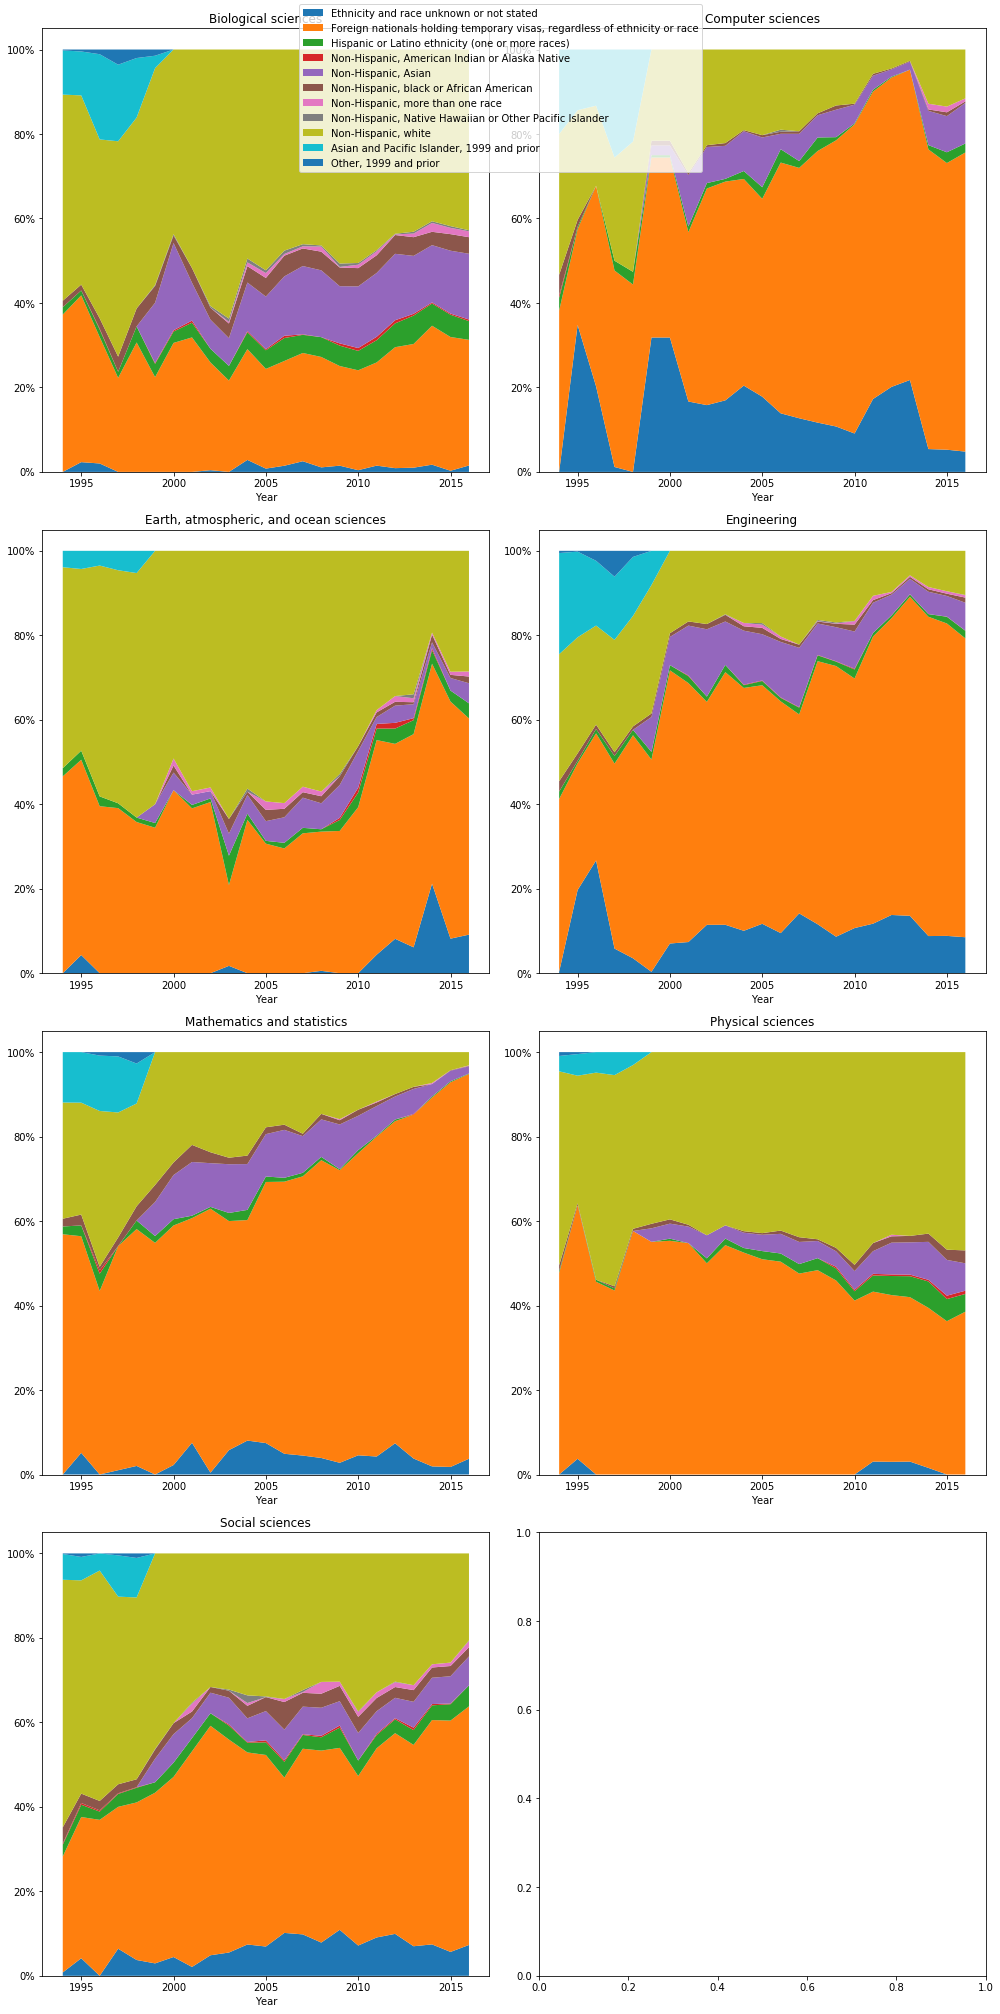

In [31]:
make_subplots(completeFields, plotter=stack_proportions)

In [27]:
# Plots raw counts of every race/ethnicity onto a subplot
def plot_counts(ax, field, exclude=None, legend=False):
    for r in race_ethnicities:
        if r != exclude:
            ax.plot(
                years,
                [counts[year][field].get(r, 0) for year in years],
                label=r,
            )

    ax.set(title=field, xlabel='Year')

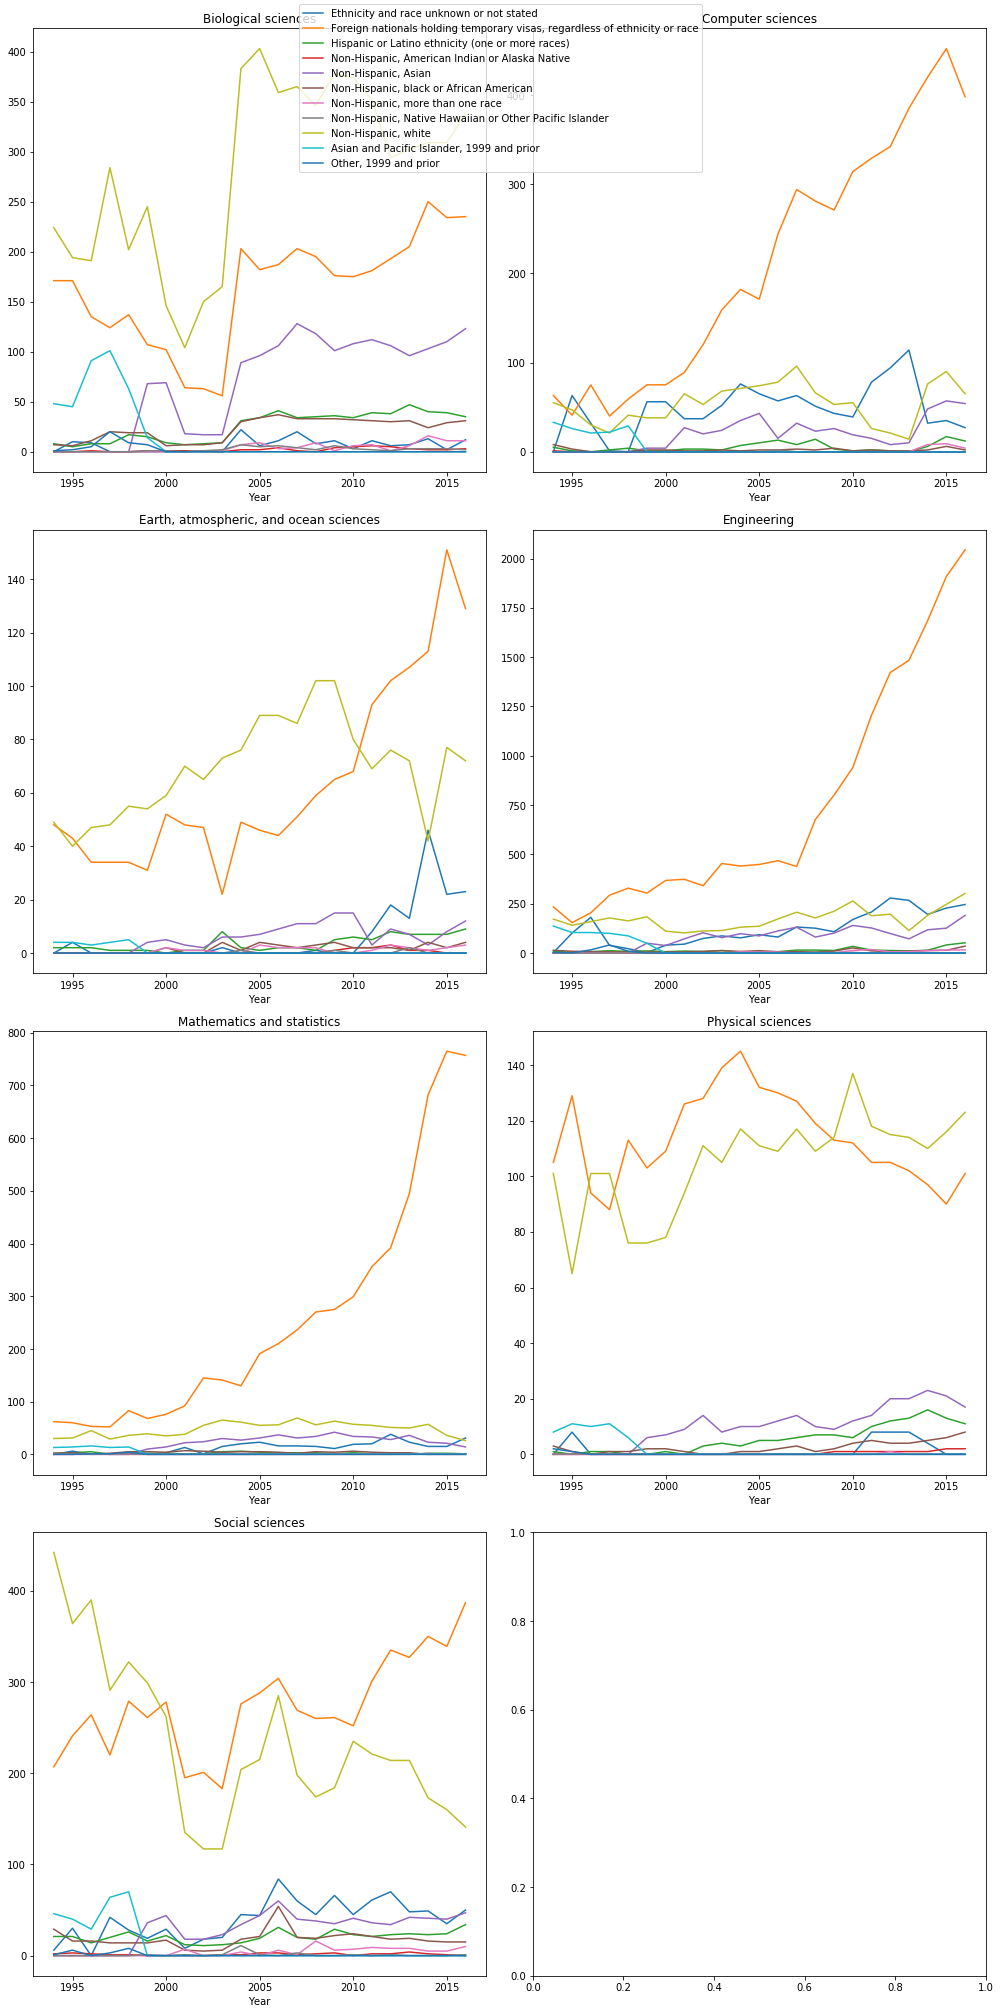

In [32]:
make_subplots(completeFields, plotter=plot_counts)

It seems like the rise in international students skews the proportions for fields where the primary purpose of its population rise is international student enrollment. Let's graph these fields without international students.

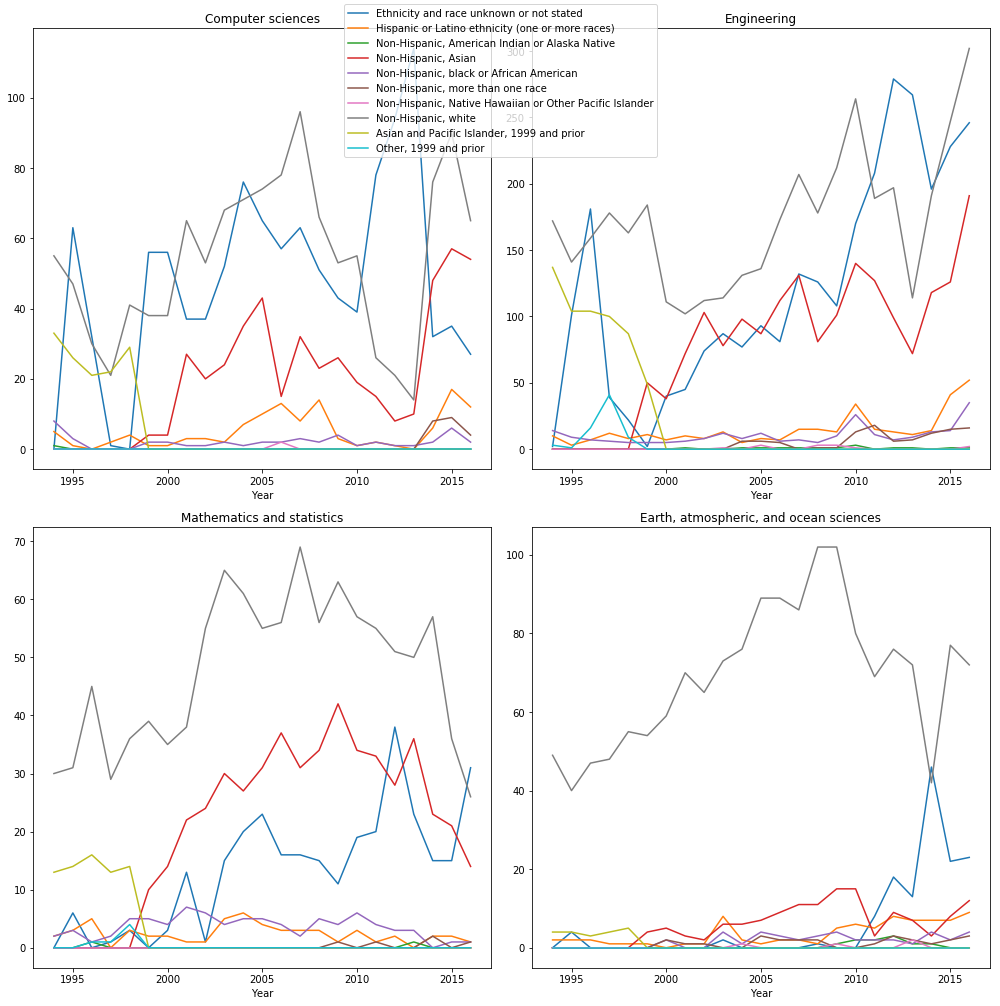

In [38]:
make_subplots(
    ['Computer sciences', 'Engineering', 'Mathematics and statistics', 'Earth, atmospheric, and ocean sciences'],
    plotter=plot_counts,
    kwargs={'exclude': 'Foreign nationals holding temporary visas, regardless of ethnicity or race'}
)

And, what do the stack plots look like without international students?

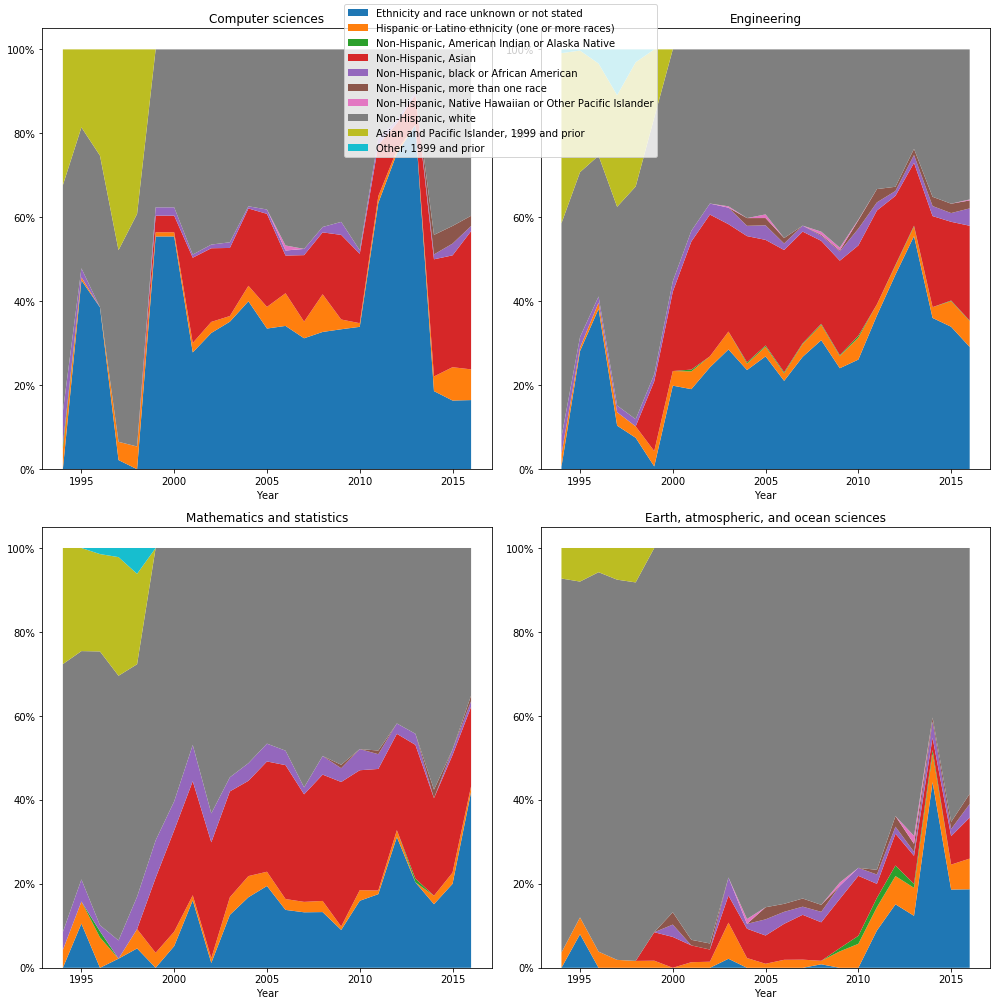

In [39]:
make_subplots(
    ['Computer sciences', 'Engineering', 'Mathematics and statistics', 'Earth, atmospheric, and ocean sciences'],
    plotter=stack_proportions,
    kwargs={'exclude': 'Foreign nationals holding temporary visas, regardless of ethnicity or race'}
)

# Findings